# Defect Detection Model

Here, we build a model to detect the presence/absence of defect (any kind) in a submersible pump impeller using Transfer Learning (with VGG16 base model)

**Dataset**: [Submersible Pump Impeller Defect Dataset](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

## Preliminaries

In [18]:
import os
os.chdir("/content/drive/My Drive/ME781 Project")

In [19]:
import matplotlib
matplotlib.use("Agg")

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model, load_model
from keras.applications import VGG16
from keras.layers.core import Flatten, Dense, Dropout
from keras.preprocessing import image
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

## Model Architecture [Using VGG16 as Base Model]

In [20]:
CLASSES = 2
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

In [21]:
def create_defect_detection_model():
	baseModel = VGG16(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(WIDTH, HEIGHT, CHANNELS)))

	# Enable Transfer Learning by freezing weights of the base VGG16 Model
	for layer in baseModel.layers:
		layer.trainable = False

	model = Sequential()
	model.add(baseModel)
	model.add(Flatten(name="flatten"))
	model.add(Dense(1024, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(256, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(CLASSES, activation='softmax'))
 
	return model

## Dataset Preparation

In [22]:
# Image preprocessing for robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=(0.5,1),
    height_shift_range=(-0.1, 0.1),
    width_shift_range=(-0.1, 0.1),
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
BATCH_SIZE = 50

print("[INFO] loading images...")
train_data_dir = "./dataset_pump_impeller/train"     # directory of training data
test_data_dir = "./dataset_pump_impeller/test"       # directory of test data

training_set = train_datagen.flow_from_directory(train_data_dir, 
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE, 
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_data_dir, 
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size=BATCH_SIZE, 
                                            class_mode='categorical',
                                            shuffle=False)

[INFO] loading images...
Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


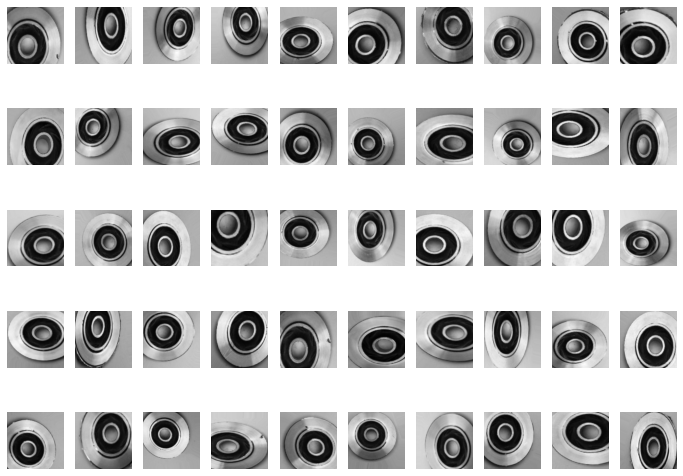

In [24]:
# Plot some images form the augmented results

x_batch, y_batch = next(training_set)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    # img = (img - np.min(img))/(np.max(img) - np.min(img))
    plt.subplot(5, 10, k+1)
    # im = Image.open(img).convert('RGB')
    plt.imshow(np.asarray(img)[:, :, ])
    plt.axis('off')

## Model training

In [25]:
print("[INFO] compiling model...")

model = create_defect_detection_model()
model.summary()
model.compile(
    loss="categorical_crossentropy", 
    optimizer = Adam(lr=0.001), 
    metrics=["accuracy"]
)

[INFO] compiling model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)             

In [26]:
print("[INFO] training model...")

EPOCHS = 20

history = model.fit(
    training_set,
    epochs=EPOCHS,
    steps_per_epoch=training_set.samples//BATCH_SIZE,
    validation_data=test_set,
    validation_steps=test_set.samples//BATCH_SIZE
)

[INFO] training model...
Epoch 1/20
132/132 [==============================] - 3889s 29s/step - loss: 1.2840 - accuracy: 0.5520 - val_loss: 0.6273 - val_accuracy: 0.9114
Epoch 2/20
132/132 [==============================] - 92s 698ms/step - loss: 0.5614 - accuracy: 0.7038 - val_loss: 0.5240 - val_accuracy: 0.6900
Epoch 3/20
132/132 [==============================] - 91s 690ms/step - loss: 0.3969 - accuracy: 0.8163 - val_loss: 0.4002 - val_accuracy: 0.7871
Epoch 4/20
132/132 [==============================] - 91s 689ms/step - loss: 0.3476 - accuracy: 0.8356 - val_loss: 0.1924 - val_accuracy: 0.9114
Epoch 5/20
132/132 [==============================] - 92s 700ms/step - loss: 0.3276 - accuracy: 0.8403 - val_loss: 0.1686 - val_accuracy: 0.9400
Epoch 6/20
132/132 [==============================] - 97s 735ms/step - loss: 0.3961 - accuracy: 0.7720 - val_loss: 0.4010 - val_accuracy: 0.7829
Epoch 7/20
132/132 [==============================] - 97s 732ms/step - loss: 0.4409 - accuracy: 0.7454 - 

In [27]:
# Save the model
print("[Info] serializing network...")
model.save("defect_detection_vgg16_new.hdf5")

[Info] serializing network...


In [28]:
# Function to plot the accuracy & losses over epochs of training

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b*--', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'rD:', label="Validation Accuracy")
    plt.legend()
    plt.title('Training and validation accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b*--', label="Training Loss")
    plt.plot(epochs, val_loss, 'rD:', label="Validation Loss")
    plt.legend()
    plt.title('Training and validation loss')
    
    plt.savefig("defect_detection_model.png", bbox_inches="tight")
    plt.show()

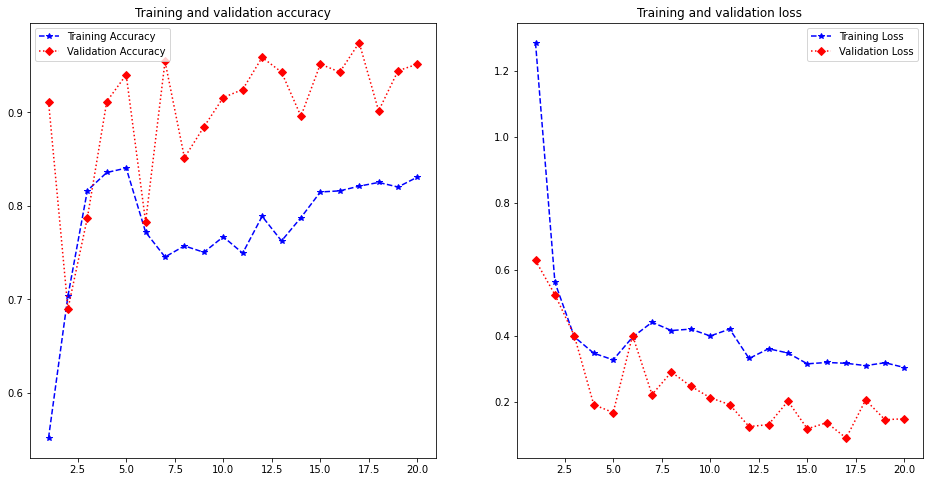

In [29]:
plot_training(history)

## Model Evauation

In [30]:
score = model.evaluate(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

15/15 [==============================] - 3s 199ms/step - loss: 0.1489 - accuracy: 0.9524
Test loss: 0.1489180326461792
Test accuracy: 0.9524475336074829


In [31]:
pred = model.predict(
    test_set, 
    steps=test_set.samples//BATCH_SIZE + 1,
    verbose=1
)
pred = np.argmax(pred, axis=1)

15/15 [==============================] - 3s 178ms/step


In [32]:
print('Confusion Matrix')
print(confusion_matrix(test_set.classes[test_set.index_array], pred))

print('\nClassification Report')
target_names = ['Defective', 'OK']
print(classification_report(test_set.classes[test_set.index_array], pred, target_names=target_names))

Confusion Matrix
[[419  34]
 [  0 262]]

Classification Report
              precision    recall  f1-score   support

   Defective       1.00      0.92      0.96       453
          OK       0.89      1.00      0.94       262

    accuracy                           0.95       715
   macro avg       0.94      0.96      0.95       715
weighted avg       0.96      0.95      0.95       715



In [33]:
def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("Defective", "OK")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

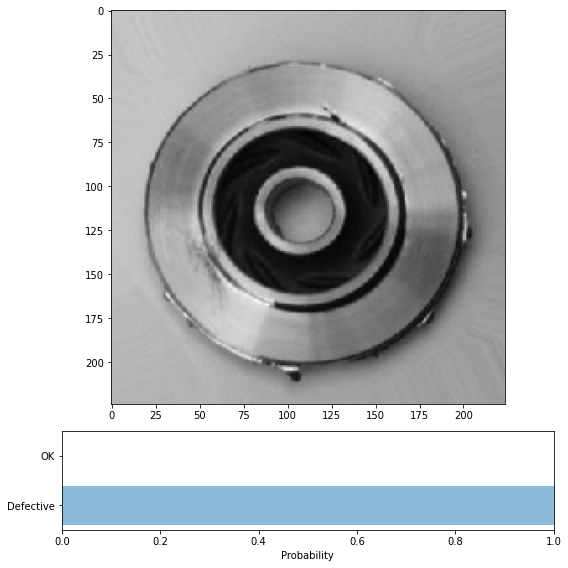

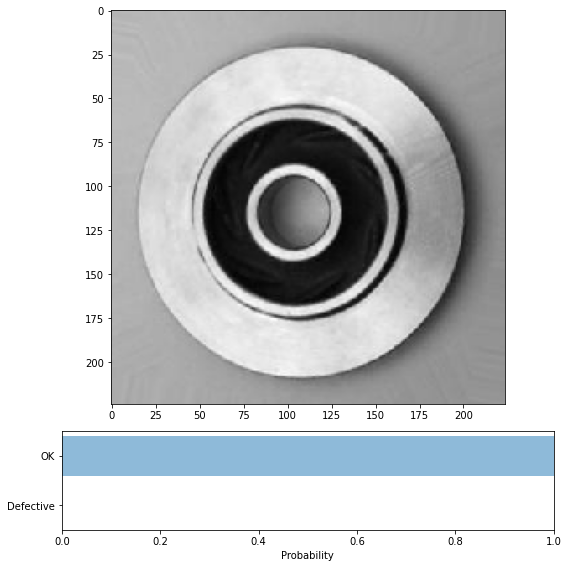

In [35]:
# Load two images, one form each class & predict the class using the trained model

img = image.load_img('/content/drive/My Drive/ME781 Project/dataset_pump_impeller/test/def_front/cast_def_0_85.jpeg', target_size=(WIDTH, HEIGHT))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)

img = image.load_img('/content/drive/My Drive/ME781 Project/dataset_pump_impeller/test/ok_front/cast_ok_0_1020.jpeg', target_size=(WIDTH, HEIGHT))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)

In [ ]:
model_loaded = load_model("defect_detection_vgg16.hdf5")